<a href="https://colab.research.google.com/github/Poohi5/cmpe258_homework/blob/master/Graded_Assignment_5/Graded_Assignment_5_Date_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Faker

     |████████████████████████████████| 1.0MB 8.9MB/s 


In [2]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
# from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt

fake = Faker()
# fake.seed(12345)
random.seed(12345)

# Define format of the data we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# change this if you want it to work with another language
LOCALES = ['en_US']

def load_date():
    """
        Loads some fake dates 
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
    
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep


def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary
    
    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters 
    
    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """
    
    l = [inv_vocab[i] for i in ints]
    return l


EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007']

def run_example(model, input_vocabulary, inv_output_vocabulary, text):
    encoded = string_to_int(text, TIME_STEPS, input_vocabulary)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return int_to_string(prediction, inv_output_vocabulary)

def run_examples(model, input_vocabulary, inv_output_vocabulary, examples=EXAMPLES):
    predicted = []
    for example in examples:
        predicted.append(''.join(run_example(model, input_vocabulary, inv_output_vocabulary, example)))
        print('input:', example)
        print('output:', predicted[-1])
    return predicted


def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
        

def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 6, Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # Normalize attention map
#     row_max = attention_map.max(axis=1)
#     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

In [4]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 18864.98it/s]


In [5]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [6]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 19 feb 1980
Target date: 1980-02-19

Source after preprocessing (indices): [ 4 12  0 18 17 14  0  4 12 11  3 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10  9  1  0  1  3  0  2 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [0]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [0]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor to propagate concat through a small fully-connected neural network to compute the "energies" variable e. (≈1 lines)
    e = densor1(concat)
    e = densor2(e)
    # Use activator and e to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(e)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

In [0]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [0]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Step 2: Iterate 
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    ### END CODE HERE ###
    
    return model

In [0]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [0]:
out = model.compile(optimizer=Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01),
                    metrics=['accuracy'],
                    loss='categorical_crossentropy')
out

In [0]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [14]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
10000/10000 [==============================] - 21s 2ms/step - loss: 16.5082 - dense_3_loss: 2.5615 - dense_3_accuracy: 0.4505 - dense_3_accuracy_1: 0.6912 - dense_3_accuracy_2: 0.3261 - dense_3_accuracy_3: 0.0895 - dense_3_accuracy_4: 0.9458 - dense_3_accuracy_5: 0.3627 - dense_3_accuracy_6: 0.0563 - dense_3_accuracy_7: 0.9446 - dense_3_accuracy_8: 0.2349 - dense_3_accuracy_9: 0.1036


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 64)       17920       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]               

<Figure size 432x288 with 0 Axes>

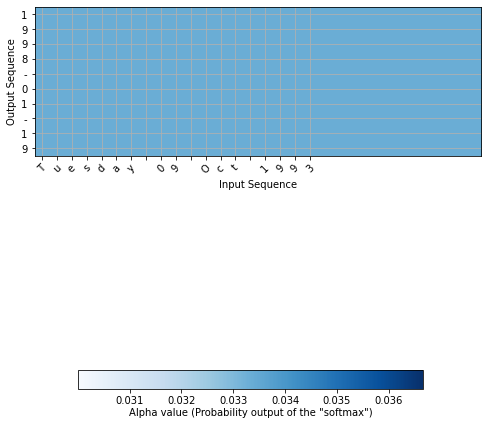

In [16]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)